<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EA%B2%B0%EA%B3%BC%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 문제정의

이번 프로젝트 주제는 **"씬파일러를 위한 신용평가 예측모형"** 입니다.  
 씬파일러(Thin filer)란, 금융 거래가 적거나 없어 관련 서류가 얇은 금융고객을 의미합니다. 주로 사회초년생, 주부, 은퇴자들이 이에 속해 있으며, 이들은 중저신용등급으로 책정되어 제도권 금융을 이용할 기회가 줄어들게 됩니다.
 이처럼 금융이력이 부족한 이들의 채무불이행을 예측하고, 더 나아가 신파일러들의 금융 불이익을 해소 할 수 있는 신용평가를 제공하는 것이 이번 프로젝트의 목적입니다.




프로젝트에 사용할 데이터는 **"Lending Club(렌딩 클럽)"** 데이터입니다.  
렌딩 클럽은 미국 유명 P2P 대출 업체로서, 신용등급이 낮아 제도권 금융기관에서 대출을 받을 수 없는 씬파일러에게 대안금융 역할을 하고 있습니다. 캐글에서 제공하고 있는 'Lending Club 2007-2020Q3' 데이터세트의 2018년부터 2020년 3분기 데이터를 활용하여 본 프로젝트를 진행하겠습니다.  



렌딩 클럽 데이터는 대출상태(loan_status)를 상환, 유지, 연체, 회수불능 등 8개로 분류하였습니다. 이를 **정상(상환, 유지)과 불량(연체, 회수불능)으로 이진 분류 문제**를 풀어내겠습니다.

# 2. EDA 및 데이터 전처리

## 2.1 데이터 및 모듈 불러오기

In [1]:
#! pip install --upgrade imbalanced-learn

In [2]:
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn

In [3]:
#!pip install category_encoders

In [4]:
#!pip install catboost

In [5]:
#!pip install lightgbm

In [6]:
#! pip install pdpbox

In [7]:
#! pip install shap

In [8]:
import pandas as pd
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [73]:
df = pd.read_csv('LendingClub_Loan_status_2018-2020Q3.csv').iloc[:,1:]
print(df.shape)
df.head()

(365327, 141)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,133154854,28000.0,28000.0,28000.0,60 months,14.03%,651.95,C,C2,CEO,10+ years,MORTGAGE,125000.0,Verified,May-2018,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,550xx,MN,16.68,0.0,May-1996,685.0,689.0,0.0,27.0,NaN,13.0,0.0,40882.0,75.8%,22.0,w,0.00,0.00,9905.010000,9905.01,...,0.0,0.0,0.0,1.0,95.5,57.1,0.0,0.0,423905.0,43815.0,28000.0,19068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,133296608,6025.0,6025.0,6025.0,36 months,9.58%,193.23,B,B1,Foreman,10+ years,MORTGAGE,75000.0,Verified,May-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,018xx,MA,8.81,0.0,Sep-2005,660.0,664.0,0.0,40.0,NaN,3.0,0.0,0.0,0%,18.0,w,0.00,0.00,6345.220166,6345.22,...,0.0,0.0,0.0,1.0,61.1,0.0,0.0,0.0,408401.0,31047.0,800.0,38249.0,10643.0,640.0,644.0,Apr-1994,0.0,4.0,8.0,29.6,1.0,18.0,0.0,1.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,133465963,9000.0,9000.0,9000.0,36 months,11.05%,294.87,B,B4,Account Manager,1 year,MORTGAGE,140000.0,Not Verified,May-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,802xx,CO,10.59,0.0,Feb-2003,695.0,699.0,0.0,38.0,NaN,8.0,0.0,9024.0,41.8%,35.0,w,3335.51,3335.51,7030.960000,7030.96,...,0.0,0.0,0.0,5.0,97.1,50.0,0.0,0.0,81369.0,54836.0,9500.0,59769.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,133498757,25000.0,25000.0,25000.0,36 months,10.07%,807.51,B,B2,ship metal mechanic,10+ years,MORTGAGE,86800.0,Source Verified,May-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,322xx,FL,18.14,0.0,Mar-1996,675.0,679.0,0.0,46.0,NaN,26.0,0.0,34132.0,45.8%,50.0,w,10623.60,10623.60,17737.250000,17737.25,...,0.0,0.0,0.0,1.0,98.0,81.8,0.0,0.0,264608.0,34132.0,38700.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,CVD19SKIP,INCOMECURT,ACTIVE,2.0,0.0,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,178.3,10688.97,807.51,N
4,133843310,10000.0,10000.0,10000.0,60 months,14.52%,235.39,C,C3,Server,10+ years,RENT,36000.0,Not Verified,May-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,925xx,CA,20.03,0.0,Jun-2004,770.0,774.0,0.0,NaN,NaN,13.0,0.0,4867.0,17.7%,17.0,w,0.00,0.00,11494.790925,11494.79,...,0.0,0.0,0.0,0.0,100.0,28.6,0.0,0.0,51989.0,18659.0,16100.0,24489.0,18456.0,660.0,664.0,Aug-2006,1.0,0.0,11.0,74.2,0.0,12.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


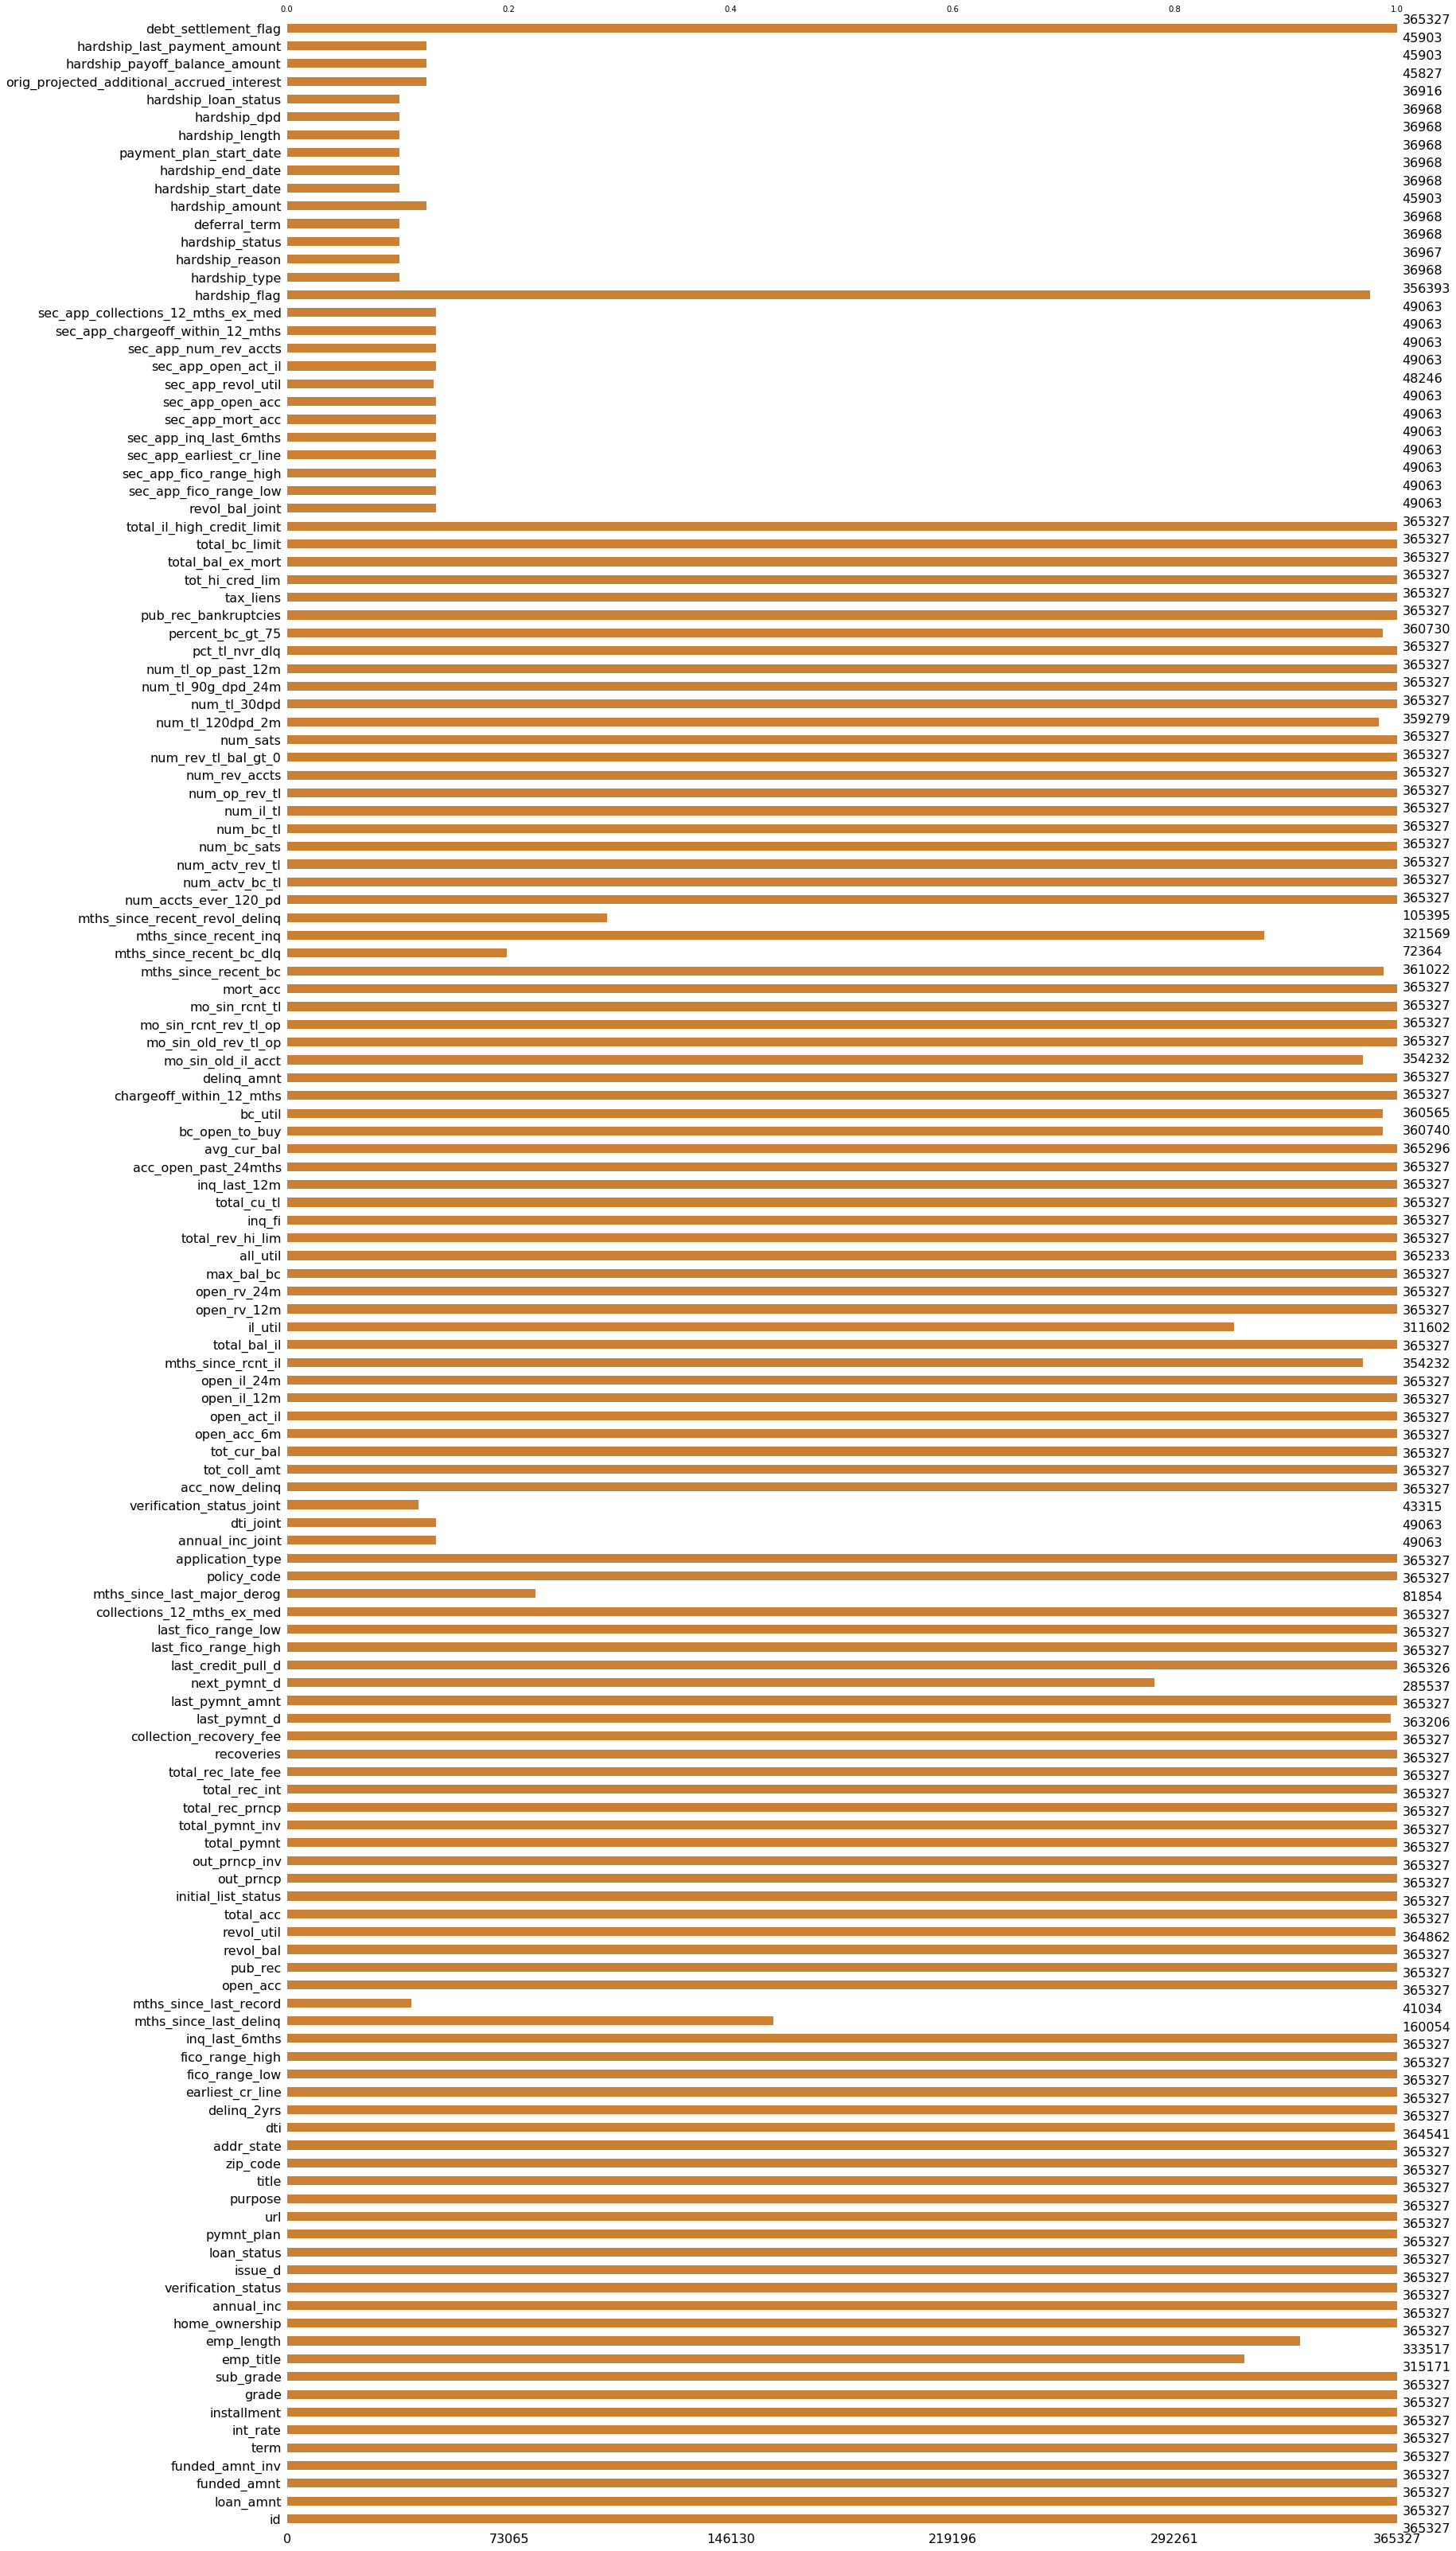

In [10]:
msno.bar(df=df.iloc[:, :], color=(0.8, 0.5, 0.2))

## 2.2 데이터 전처리

1. 대출 후 생성 변수 제거
2. 최빈값의 빈도가 99% 이상인 범주형 변수 제거
3. 범주형 데이터 타입 정리
4. 범주의 수가 50개 이상인 변수 제거
5. 결측값 절반 이상 칼럼 제거

### 2.2.1 대출 후 생성 변수 제거  
렌딩클럽 데이터에는 대출 생성 전에는 존재하지 않는 대출 수 생성 변수가 존재한다. 대출 후 생성 변수는 모형에 학습될 경우, 과적합될 가능성이 높아진다.   
recoveries와 같은 변수는 추심된 금액 중 회복된 금액을 설명한다. 이와 유사하게 대출 후 생성 변수 30개를 제거한다. 

In [74]:
recoveries_list = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'hardship_flag',
'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
'hardship_last_payment_amount','last_fico_range_high', 'last_fico_range_low']

In [75]:
df.drop(columns=recoveries_list,axis=1, inplace=True)

### 2.2.2 최빈값의 빈도가 99% 이상인 범주형 변수 제거  
최빈값의 빈도가 99% 이상인 범주형 변수는 모형에 학습된다고 해도 결과 변수에 영향을 주지못한다.


In [76]:
mode_99_list = ['pymnt_plan', 'policy_code', 'debt_settlement_flag', 
                'num_tl_120dpd_2m', 'acc_now_delinq', 'num_tl_30dpd']

In [77]:
df.drop(columns=mode_99_list,axis=1, inplace=True)

### 2.2.3 범주형 데이터 타입 정리
emp_length는 재직 기간을 의미하는 변수로, 범주의 수가 10개 이상으로 dummy encoding을 진행할 경우 차원이 10개 이상 늘어나게 된다. 따라서 이를 방지하기 위해 범주군을 묶어주었다.
- less than 3 years: 1년 이하 ~ 3년
- more than 4 years and less than 9 years: 4년 ~ 9년
- 10+ years: 10년 이상
- unemployed: nan

In [78]:
df.loc[(df['emp_length']== '< 1 year')|(df['emp_length']== '1 year')|(df['emp_length']== '2 years')|(df['emp_length']== '3 years'),'emp_length'] = 'less than 3 years'
df.loc[(df['emp_length']== '4 years')|(df['emp_length']== '5 years')|(df['emp_length']== '6 years')|(df['emp_length']== '7 years')|(df['emp_length']== '8 years')|(df['emp_length']== '9 years'),'emp_length'] = 'more than 4 years and less than 9 years'
df['emp_length'].fillna('unemployed', inplace=True)

purpose의 경우 대출 목적의 의미를 가진 변수로, 이 또한 범주군을 묶어주었다.
- General loan debt: car, home_improvement, house, major_purchase, medical, moving,
other, renewable_energy, small_business, vacation, wedding 
- credit_card: credit_card
- debt_consolidation: debt_consolidation

In [79]:
df.loc[(df['purpose']== 'car')|(df['purpose']== 'home_improvement')|(df['purpose']== 'house')|(df['purpose']== 'major_purchase')|
       (df['purpose']== 'medical')|(df['purpose']== 'moving')|(df['purpose']== 'other')|(df['purpose']== 'renewable_energy')|(df['purpose']== 'small_business')|
       (df['purpose']== 'vacation')|(df['purpose']== 'wedding'),'purpose'] = 'General loan debt'

int_rate, revol_util 변수는 %가 붙어 있으므로, 수치형으로 변환해주었다.

In [80]:
df[['int_rate', 'revol_util']] = df[['int_rate', 'revol_util']].replace('%','', regex=True).apply(pd.to_numeric)

### 2.2.4 범주의 수가 50개 이상인 변수 제거

In [81]:
selected_cols = df.select_dtypes(include='object')
colnames = selected_cols.columns.tolist()
labels = selected_cols.nunique()

selected_features = labels[labels >= 50].index.tolist()

In [82]:
df.drop(columns=selected_features,axis=1, inplace=True)

### 2.2.5 결측값 절반 이상 칼럼 제거

In [83]:
df.dropna(thresh=int(len(df) * 0.5), axis=1, inplace=True)

### 2.2.6 변수 생성
loan_status 변수를 정상(0)과 불량(1)으로 이진 분류해주었다.
- 0: Fully Paid, Current
- 1: Late (31-120 days), Charged Off, In Grace Period, Late (16-30 days), Default, Issued

In [84]:
df.loc[(df['loan_status']== 'Fully Paid')|(df['loan_status']== 'Current'),"loan_payment"]= 0

In [85]:
df.loc[(df['loan_status']== 'Late (31-120 days)')|(df['loan_status']== 'Charged Off')|
       (df['loan_status']== 'In Grace Period')|(df['loan_status']== 'Late (16-30 days)')|
       (df['loan_status']== 'Default')|(df['loan_status']== 'Issued')|
       (df['loan_status']== 'Late (31-120 days)'),'loan_payment'] = 1

## 2.3 EDA

In [86]:
df.shape

(365327, 80)

In [24]:
df.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_low,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_payment
count,3.653270e+05,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,3.653270e+05,364541.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,3.653270e+05,364862.000000,365327.000000,365327.00000,365327.000000,3.653270e+05,365327.000000,365327.000000,365327.000000,365327.000000,354232.000000,3.653270e+05,311602.000000,365327.000000,365327.000000,365327.000000,365233.000000,3.653270e+05,365327.000000,365327.000000,365327.000000,365327.000000,365296.000000,360740.000000,360565.000000,365327.000000,365327.000000,354232.000000,365327.000000,365327.000000,365327.000000,365327.000000,361022.000000,321569.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,365327.000000,360730.000000,365327.000000,365327.000000,3.653270e+05,3.653270e+05,3.653270e+05,3.653270e+05,365327.000000
mean,1.496524e+08,16155.107753,16155.107753,16152.369860,12.872478,468.579760,8.386564e+04,20.390653,0.233073,706.104613,710.104898,0.461584,11.698421,0.113955,1.717614e+04,44.297133,23.072491,698.27018,176.664120,1.490871e+05,0.917679,2.823057,0.709493,1.617638,19.669824,3.760462e+04,68.477625,1.196388,2.509601,6161.949850,54.584868,4.015098e+04,1.148582,1.563200,1.917575,4.399787,13922.129273,15876.783526,49.717748,0.006613,1.005647,124.608660,172.538244,15.607927,8.613798,1.339622,25.698226,7.414238,0.464940,3.720582,5.457270,4.983957,7.154043,8.591396,8.259450,12.944609,5.433417,11.681390,0.059311,2.033953,94.706868,32.562879,0.113608,0.000203,1.917199e+05,5.519371e+04,2.819770e+04,4.841059e+04,0.072245
std,1.070948e+07,10198.397642,10198.397642,10198.767971,5.056036,287.509266,1.099274e+05,20.572719,0.750749,35.361821,35.362943,0.742231,6.003019,0.324002,2.323538e+04,24.879119,12.282022,81.72473,1490.130179,1.712903e+05,1.131476,2.963252,0.942897,1.577224,23.901079,4.758035e+04,23.427173,1.463503,2.498837,6078.095074,20.565602,3.829393e+04,1.500354,2.770547,2.311864,3.204916,17288.242300,20105.663435,28.664482,0.092710,177.977680,57.148292,99.842919,19.096380,9.354862,1.724056,33.514780,6.045747,1.388643,2.476692,3.463554,3.231954,4.546651,7.516462,4.975189,7.917040,3.424480,5.999122,0.416372,1.879364,8.949442,34.489336,0.322757,0.023043,1.934519e+05,5.584763e+04,2.677034e+04,4.965310e+04,0.258893
min,7.461704e+07,1000.000000,1000.000000,725.000000,5.310000,30.120000,0.000000e+00,0.000000,0.000000,660.000000,664.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.00000

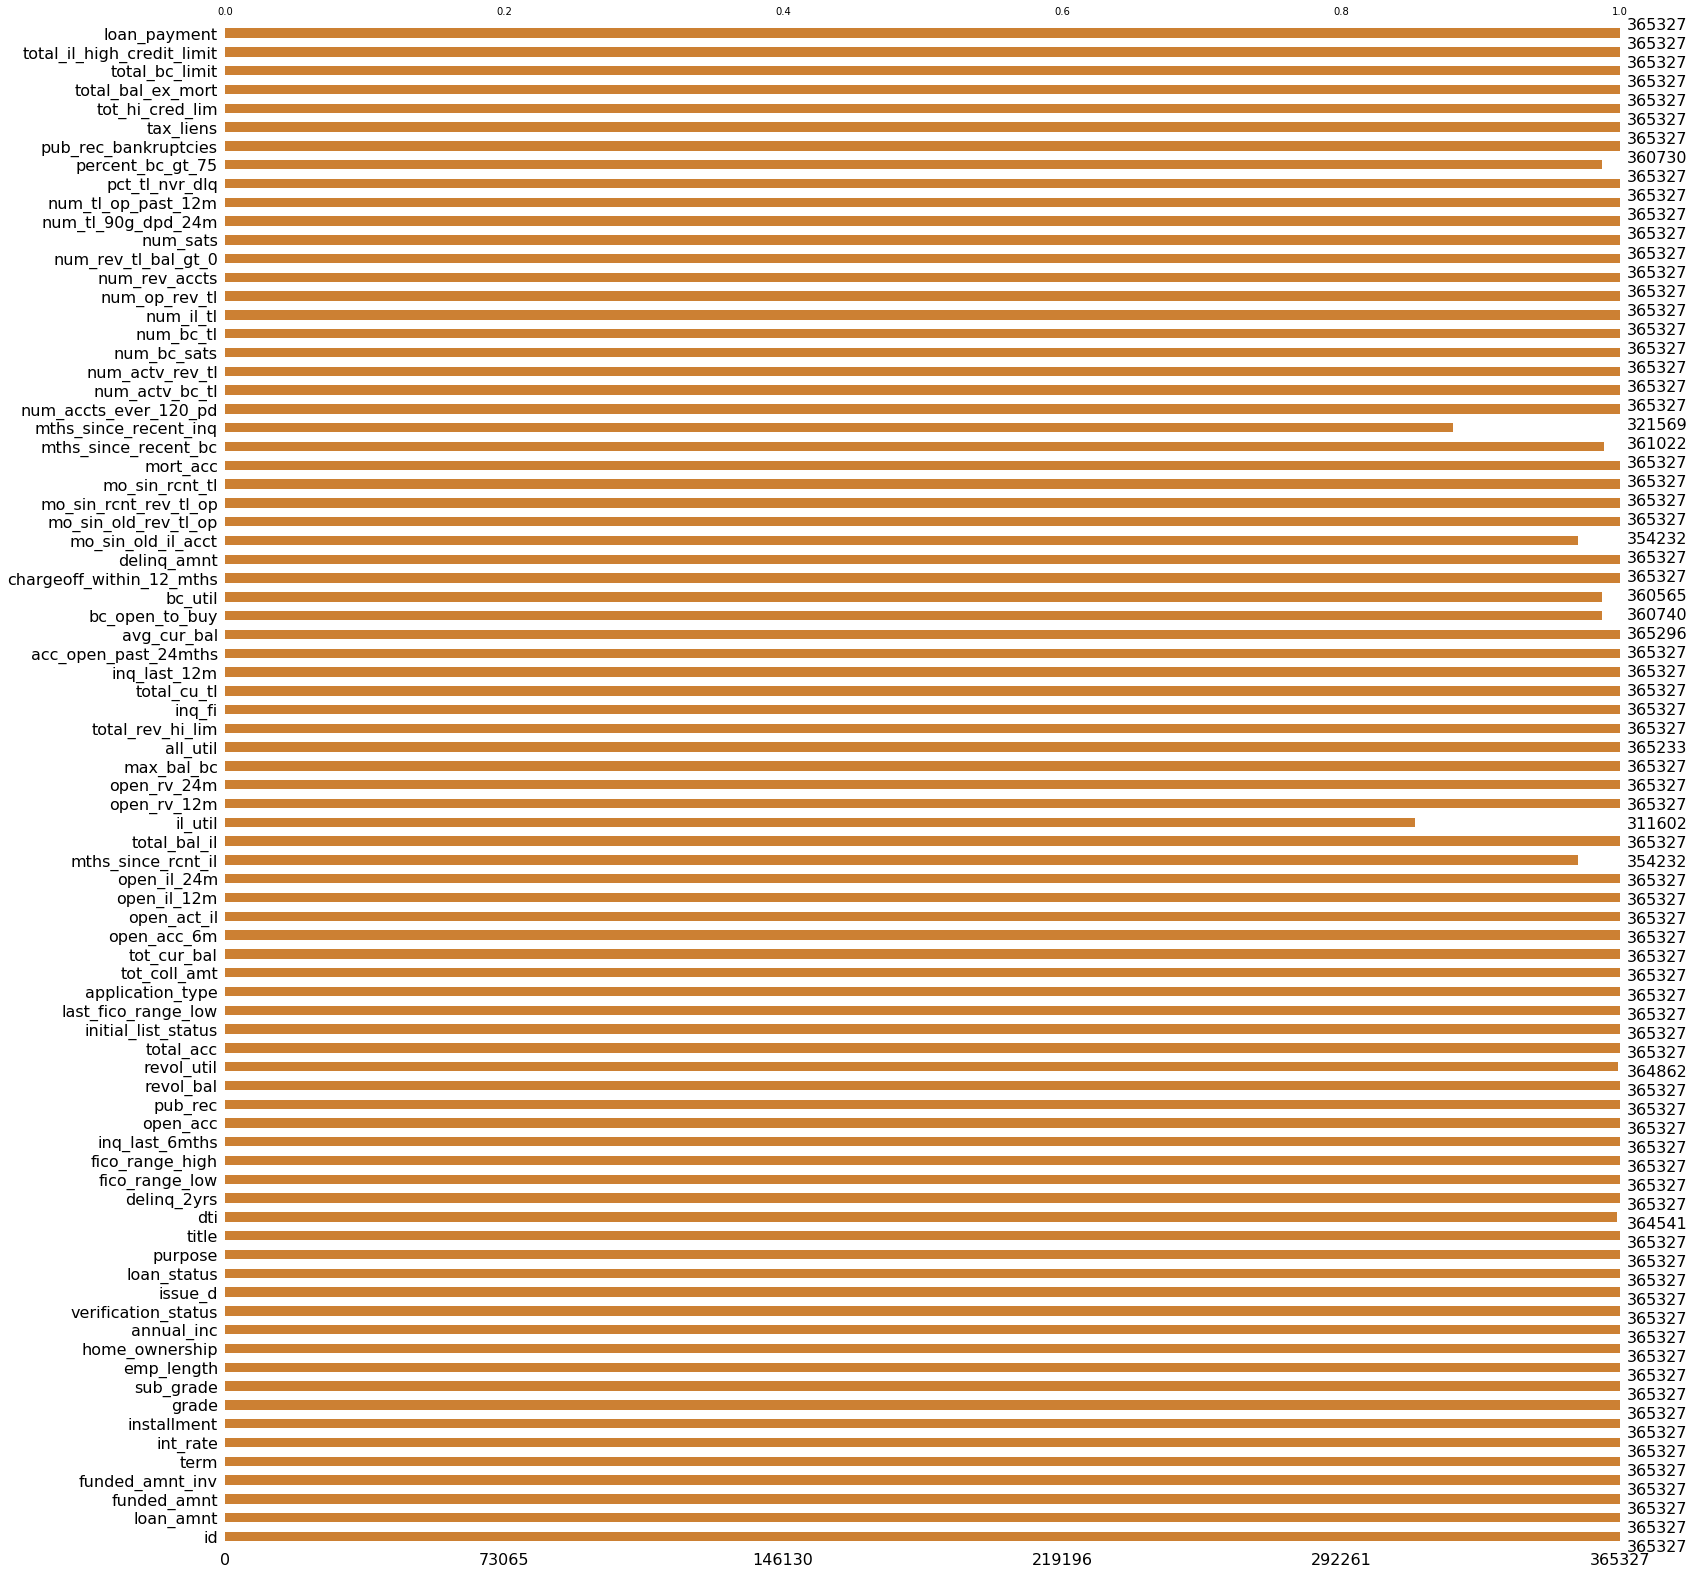

In [25]:
msno.bar(df=df.iloc[:, :], color=(0.8, 0.5, 0.2))

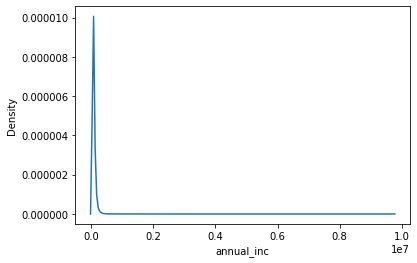

In [26]:
sns.kdeplot(x=df["annual_inc"])

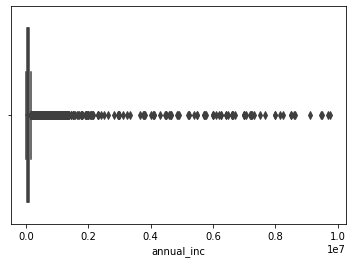

In [27]:
sns.boxplot(df['annual_inc'])

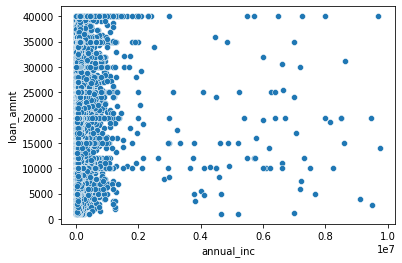

In [28]:
sns.scatterplot(data = df, x ='annual_inc' , y ='loan_amnt')

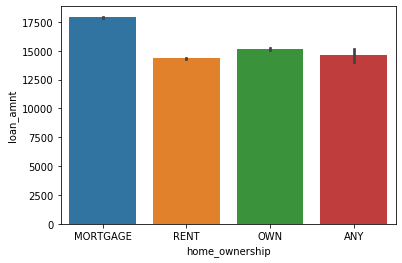

In [29]:
sns.barplot(x='home_ownership', y = 'loan_amnt', data = df)

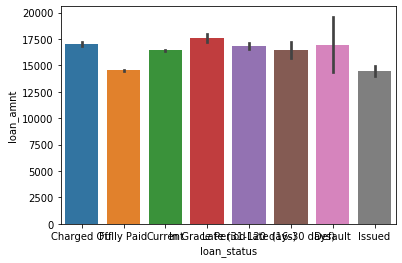

In [30]:
sns.barplot(x='loan_status', y = 'loan_amnt', data = df)

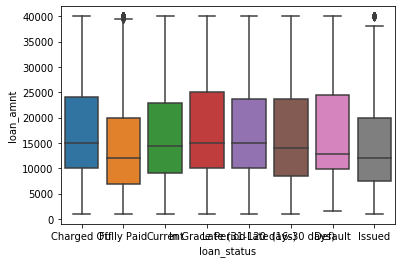

In [31]:
sns.boxplot(y = df['loan_amnt'], x = df['loan_status'])

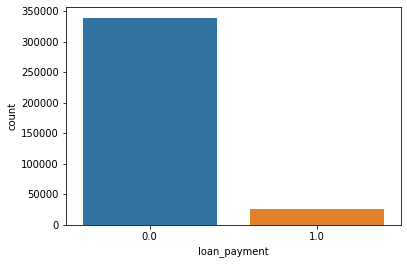

In [32]:
sns.countplot(x = df['loan_payment'])

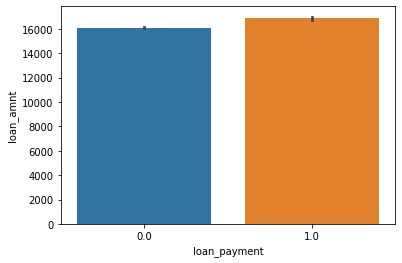

In [33]:
sns.barplot(x='loan_payment', y = 'loan_amnt', data = df)

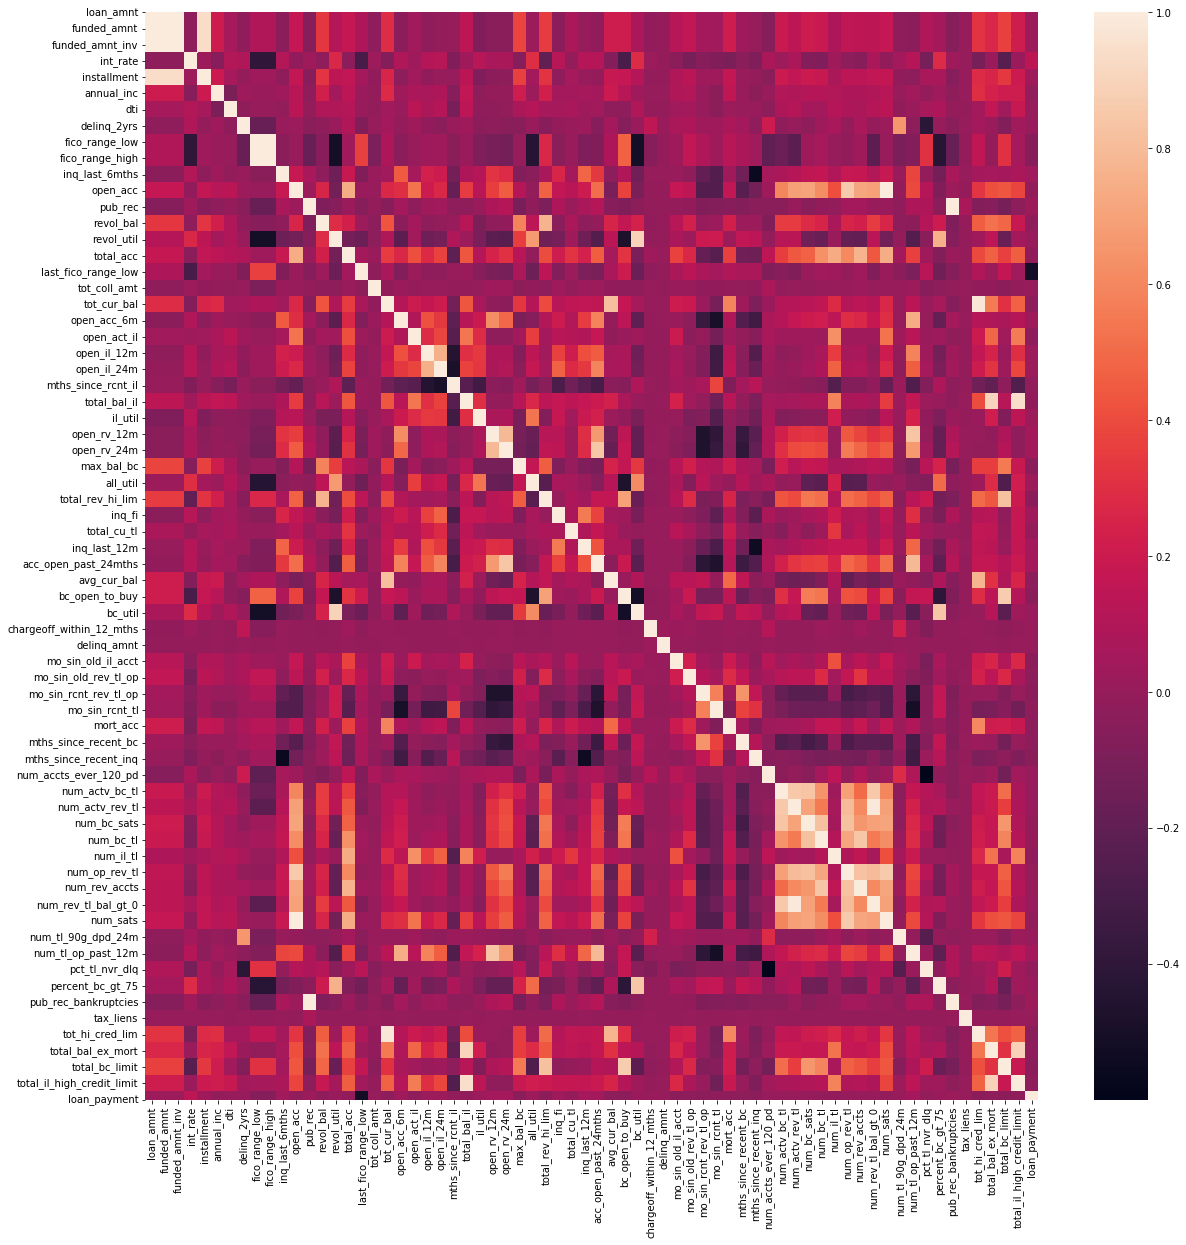

In [34]:
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns=['loan_status','id','issue_d','grade']).corr())

# 3. 모델링

In [35]:
# 평가지표 함수
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label: 1")
    print("Accuracy: {:.1%}".format(Accuracy))
    print("Precision: {:.1%}".format(Precision))
    print("Recall: {:.1%}".format(Recall))
    print("F1-Score: {:.1%}".format(F1_Score))

## 3.1 타겟 지정 및 데이터 세트 분할

In [87]:
target= 'loan_payment'

# test set 만들기
test = df[(df['issue_d'] == 'Sep-2020') | (df['issue_d'] == 'May-2020')]
train = df.drop(test.index)

# validation set 만들기
train, val = train_test_split(train, train_size = 0.8, stratify=train[target], random_state=10)

In [88]:
# target 지정 및 데이터 세트 분할
# loan_payment: Target, id: Always unique, issue_d: Date, grade: Duplicative of sub_grade
features = train.drop(columns=['loan_status','loan_payment','id','issue_d','grade']).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [89]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (280315, 75)
y_train shape (280315,)
X_val shape (70079, 75)
y_val shape (70079,)
X_test shape (14933, 75)
y_test shape (14933,)


In [90]:
# Data Processing Pipeline
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# Scailing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_val_scaled = scaler.transform(X_val_processed)

## 3.2 기본값 모델링

In [40]:
y_train.value_counts(normalize=True)

0.0    0.929315
1.0    0.070685
Name: loan_payment, dtype: float64

In [41]:
# Majority class baseline
# 기준모델 학습세트
major = y_train.mode()[0]
y_train_pred = [major] *len(y_train)
print("기준모델 학습세트 평가")
model_evaluation(y_train, y_train_pred)
print("\n")

# 기준모델 검증세트
y_val = val[target]
y_val_pred = [major] * len(y_val)
print("기준모델 검증세트 평가")
model_evaluation(y_val, y_val_pred)

기준모델 학습세트 평가
Model_Evaluation with Label: 1
Accuracy: 92.9%
Precision: nan%
Recall: 0.0%
F1-Score: nan%


기준모델 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 92.9%
Precision: nan%
Recall: 0.0%
F1-Score: nan%


In [42]:
# Logistic Regression
lr = LogisticRegression(random_state=10, n_jobs=-1)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr)

로지스틱 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.1%
Precision: 81.6%
Recall: 58.1%
F1-Score: 67.9%


In [105]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=1, max_depth=6,
                           min_samples_leaf=3, min_samples_split=2)
dtc.fit(X_train_processed, y_train)
y_pred_dtc = dtc.predict(X_val_processed)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc)

결정트리 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 92.9%
Precision: 5.6%
Recall: 0.0%
F1-Score: 0.0%


In [101]:
model_evaluation(1-y_val, 1-y_pred_dtc)

Model_Evaluation with Label: 1
Accuracy: 86.4%
Precision: 93.4%
Recall: 91.9%
F1-Score: 92.6%


In [104]:
y_train_pred_dtc = dtc.predict(X_train_processed)
model_evaluation(y_train, y_train_pred_dtc)

Model_Evaluation with Label: 1
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-Score: 100.0%


In [44]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc.fit(X_train_processed, y_train)
y_pred_rfc = rfc.predict(X_val_processed)

print("렌덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc)

렌덤포레스트 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.1%
Precision: 79.5%
Recall: 60.2%
F1-Score: 68.5%


In [45]:
# XGB Classifier
xgb = XGBClassifier(random_state=10, n_jobs=-1)
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_val_processed)

print("XGBoost 검증세트 평가")
model_evaluation(y_val, y_pred_xgb)

XGBoost 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.2%
Precision: 78.8%
Recall: 63.2%
F1-Score: 70.1%


In [46]:
# LGBM Classifier
lgb = LGBMClassifier(random_state=10, n_jobs=-1)
lgb.fit(X_train_processed, y_train);
y_pred_lgb = lgb.predict(X_val_processed)

print("LGBM 검증세트 평가")
model_evaluation(y_val, y_pred_lgb)

LGBM 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.2%
Precision: 78.0%
Recall: 64.0%
F1-Score: 70.3%


In [47]:
# CatBoostClassifier
cbc = CatBoostClassifier(random_state=10)
cbc.fit(X_train_processed, y_train);
y_pred_cbc = cbc.predict(X_val_processed)

print("CatBoost 검증세트 평가")
model_evaluation(y_val, y_pred_cbc)

Learning rate set to 0.114309
0:	learn: 0.5201457	total: 136ms	remaining: 2m 16s
1:	learn: 0.3949226	total: 200ms	remaining: 1m 39s
2:	learn: 0.3185610	total: 265ms	remaining: 1m 28s
3:	learn: 0.2582503	total: 326ms	remaining: 1m 21s
4:	learn: 0.2207792	total: 386ms	remaining: 1m 16s
5:	learn: 0.1937866	total: 456ms	remaining: 1m 15s
6:	learn: 0.1768869	total: 517ms	remaining: 1m 13s
7:	learn: 0.1620115	total: 583ms	remaining: 1m 12s
8:	learn: 0.1518588	total: 641ms	remaining: 1m 10s
9:	learn: 0.1439840	total: 712ms	remaining: 1m 10s
10:	learn: 0.1390817	total: 782ms	remaining: 1m 10s
11:	learn: 0.1355279	total: 849ms	remaining: 1m 9s
12:	learn: 0.1321835	total: 907ms	remaining: 1m 8s
13:	learn: 0.1296231	total: 970ms	remaining: 1m 8s
14:	learn: 0.1277518	total: 1.04s	remaining: 1m 8s
15:	learn: 0.1260187	total: 1.1s	remaining: 1m 7s
16:	learn: 0.1250394	total: 1.18s	remaining: 1m 8s
17:	learn: 0.1239480	total: 1.25s	remaining: 1m 8s
18:	learn: 0.1231415	total: 1.31s	remaining: 1m 7s
1

## 3.4 SMOTE를 이용한 Oversampling 후 모델링

In [50]:
print("OverSampling 전, '불량(1)' 라벨의 수: {}".format(sum(y_train == 1)))
print("OverSampling 전, '정상(0)' 라벨의 수: {}".format(sum(y_train == 0)))

OverSampling 전, '불량(1)' 라벨의 수: 19814
OverSampling 전, '정상(0)' 라벨의 수: 260501


In [107]:
# SMOTE 알고리즘 활용하여 Oversampling 진행
sm = SMOTE(random_state = 10)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train.ravel()) 

In [96]:
print("OverSampling 후, '불량(1)' 라벨의 수: {}".format(sum(y_train_res == 1)))
print("OverSampling 후, '정상(0)' 라벨의 수: {}".format(sum(y_train_res == 0)))

OverSampling 후, '불량(1)' 라벨의 수: 130250
OverSampling 후, '정상(0)' 라벨의 수: 260501


In [56]:
pd.Series(y_train_res).value_counts(normalize=True)

0.0    0.666668
1.0    0.333332
dtype: float64

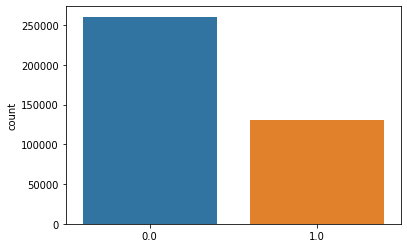

In [57]:
sns.countplot(x=pd.Series(y_train_res))

In [58]:
# Logistic Regression Over Sampling
lr2 = LogisticRegression(random_state=10, n_jobs=-1)
lr2.fit(X_train_res, y_train_res)
y_pred_lr2 = lr2.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr2)

로지스틱 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 54.3%
Precision: 12.5%
Recall: 91.4%
F1-Score: 22.0%


In [108]:
# Decision Tree Classifier Over Sampling
dtc2 = DecisionTreeClassifier(random_state=10, max_depth=6,
                           min_samples_leaf=3, min_samples_split=2)
dtc2.fit(X_train_res, y_train_res)
y_pred_dtc2 = dtc2.predict(X_val_processed)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc2)

결정트리 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 84.1%
Precision: 10.7%
Recall: 17.2%
F1-Score: 13.2%


In [110]:
# Random Forest Classifier Over Sampling
rfc2 = RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split= 18, n_estimators=300,
                           criterion='entropy', max_features='auto',n_jobs=-1, random_state=10)
rfc2.fit(X_train_res, y_train_res)
y_pred_rfc2 = rfc2.predict(X_val_processed)

print("렌덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc2)

KeyboardInterrupt: ignored

In [61]:
# XGBClassifier Over Sampling
xgb2 = XGBClassifier(random_state=10, n_jobs=-1)
xgb2.fit(X_train_res, y_train_res)
y_pred_xgb2 = xgb2.predict(X_val_processed)

print("XGBoost 검증세트 평가")
model_evaluation(y_val, y_pred_xgb2)

XGBoost 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.0%
Precision: 73.5%
Recall: 67.2%
F1-Score: 70.2%


In [62]:
# LGBM Classifier Over Sampling
lgb2 = LGBMClassifier(random_state=10, n_jobs=-1)
lgb2.fit(X_train_res, y_train_res);
y_pred_lgb2 = lgb2.predict(X_val_processed)

print("LGBM 검증세트 평가")
model_evaluation(y_val, y_pred_lgb2)

LGBM 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 96.2%
Precision: 77.7%
Recall: 64.5%
F1-Score: 70.5%


In [63]:
# CatBoostClassifier Over Sampling
cbc2 = CatBoostClassifier(random_state=10)
cbc2.fit(X_train_res, y_train_res);
y_pred_cbc2 = cbc2.predict(X_val_processed)

print("CatBoost 검증세트 평가")
model_evaluation(y_val, y_pred_cbc2)

Learning rate set to 0.131727
0:	learn: 0.5165139	total: 120ms	remaining: 1m 59s
1:	learn: 0.4108472	total: 234ms	remaining: 1m 56s
2:	learn: 0.3295415	total: 326ms	remaining: 1m 48s
3:	learn: 0.2776367	total: 441ms	remaining: 1m 49s
4:	learn: 0.2319201	total: 551ms	remaining: 1m 49s
5:	learn: 0.2042511	total: 659ms	remaining: 1m 49s
6:	learn: 0.1871518	total: 751ms	remaining: 1m 46s
7:	learn: 0.1657029	total: 857ms	remaining: 1m 46s
8:	learn: 0.1498831	total: 964ms	remaining: 1m 46s
9:	learn: 0.1380998	total: 1.07s	remaining: 1m 45s
10:	learn: 0.1293570	total: 1.17s	remaining: 1m 45s
11:	learn: 0.1248442	total: 1.28s	remaining: 1m 45s
12:	learn: 0.1191789	total: 1.4s	remaining: 1m 46s
13:	learn: 0.1154756	total: 1.51s	remaining: 1m 46s
14:	learn: 0.1124118	total: 1.61s	remaining: 1m 45s
15:	learn: 0.1104041	total: 1.7s	remaining: 1m 44s
16:	learn: 0.1074292	total: 1.8s	remaining: 1m 44s
17:	learn: 0.1060593	total: 1.91s	remaining: 1m 44s
18:	learn: 0.1031723	total: 2.01s	remaining: 1m

# 3.5 Hyperparameter Tuning 후 모델링

In [64]:
vc = y_train.value_counts().to_list()
ratio = float(vc[0]/vc[1])
ratio

13.147320076713434

In [98]:
# XGBClassifier Hyperparameter Tuning
xgb3 = XGBClassifier(random_state=10, n_jobs=-1,n_estimators=500, max_depth=7, 
                     scale_pos_weight=ratio) # weight 조절

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

xgb3.fit(X_train_processed, y_train,
         eval_set=eval_set, eval_metric='error', early_stopping_rounds=50);
y_pred_xgb3 = xgb3.predict(X_val_processed)


print("XGBoost 검증세트 평가")
model_evaluation(y_val, y_pred_xgb3)

[0]	validation_0-error:0.398973	validation_1-error:0.403359
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.329333	validation_1-error:0.333795
[2]	validation_0-error:0.31389	validation_1-error:0.319768
[3]	validation_0-error:0.311096	validation_1-error:0.316257
[4]	validation_0-error:0.295746	validation_1-error:0.301774
[5]	validation_0-error:0.309134	validation_1-error:0.315715
[6]	validation_0-error:0.311974	validation_1-error:0.318997
[7]	validation_0-error:0.309099	validation_1-error:0.315729
[8]	validation_0-error:0.311389	validation_1-error:0.319468
[9]	validation_0-error:0.311307	validation_1-error:0.319639
[10]	validation_0-error:0.310019	validation_1-error:0.317827
[11]	validation_0-error:0.311756	validation_1-error:0.320025
[12]	validation_0-error:0.311425	validation_1-error:0.319868
[13]	validation_0-error:0.312873	validation_1-error:0.321

# 3.6 Over Sampling + Hyperparameter Tuning 후 모델링

In [66]:
# RandomForestClassifier Over Sampling + Hyperparameter Tuning
rfc3 = RandomForestClassifier(random_state=10, n_jobs=-1, n_estimators=1000, max_depth=7)
rfc3.fit(X_train_res, y_train_res)
y_pred_rfc3 = rfc3.predict(X_val_processed)

print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc3)

랜덤포레스트 검증세트 평가
Model_Evaluation with Label: 1
Accuracy: 95.1%
Precision: 65.7%
Recall: 64.4%
F1-Score: 65.1%


In [ ]:
# XGBClassifier  Over Sampling + Hyperparameter Tuning
xgb4 = XGBClassifier(random_state=10, n_jobs=-1,n_estimators=500, max_depth=7, 
                     scale_pos_weight=ratio) # weight 조절

eval_set = [(X_train_res, y_train_res), 
            (X_val_processed, y_val)]

xgb4.fit(X_train_res, y_train_res,
         eval_set=eval_set, eval_metric='error', early_stopping_rounds=50);
y_pred_xgb4 = xgb4.predict(X_val_processed)


print("XGBoost 검증세트 평가")
model_evaluation(y_val, y_pred_xgb4)

# 4. 결과해석

In [99]:
feature_names = X_train.columns.tolist()
pd.Series(xgb3.feature_importances_, feature_names).sort_values(ascending=False)

int_rate              0.080012
sub_grade             0.025600
open_rv_24m           0.023103
term                  0.021858
funded_amnt_inv       0.019843
                        ...   
open_acc_6m           0.008587
num_tl_90g_dpd_24m    0.007925
tax_liens             0.003254
funded_amnt           0.000000
fico_range_high       0.000000
Length: 75, dtype: float32

In [91]:
lr_pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=10, n_jobs=-1)
)
lr_pipe.fit(X_train, y_train);

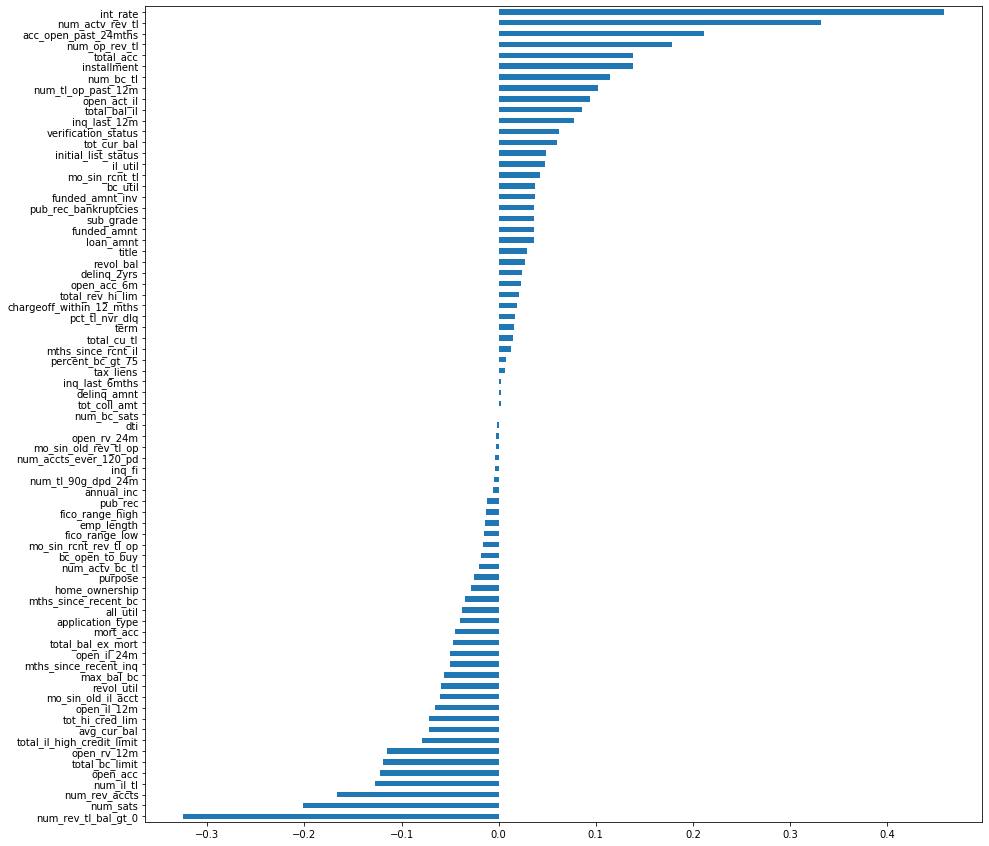

In [92]:
model_lr = lr_pipe.named_steps['logisticregression']
enc = lr_pipe.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns
coefficients = pd.Series(model_lr.coef_[0], encoded_columns)
plt.figure(figsize=(15,15))
coefficients.sort_values().plot.barh()
plt.show()

In [93]:
coefficients = pd.Series(np.around(model_lr.coef_,5)[0], encoded_columns)
coefficients.sort_values(ascending=False)

int_rate                0.45907
num_actv_rev_tl         0.33230
acc_open_past_24mths    0.21169
num_op_rev_tl           0.17826
total_acc               0.13866
                         ...   
open_acc               -0.12225
num_il_tl              -0.12722
num_rev_accts          -0.16619
num_sats               -0.20156
num_rev_tl_bal_gt_0    -0.32454
Length: 75, dtype: float64